In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, GRU
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from datetime import date, timedelta
import time
import datetime
from tensorflow import keras
from keras.layers import Bidirectional
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import SGD
%matplotlib inline

In [ ]:
hist = pd.read_csv('/content/drive/MyDrive/S7 Project/BTC.csv')
hist = hist.drop(['Number of trades'], axis=1)
hist = hist.drop(['Close time'], axis=1)
hist = hist.drop(['Quote asset volume'], axis=1)
hist = hist.drop(['Taker buy base asset volume'], axis=1)
hist = hist.drop(['Taker buy quote asset volume'], axis=1)
# hist = hist.drop(['Volume'], axis=1)
target_col = 'Close'
hist['Open time'] = pd.to_datetime(hist['Open time']/1000, unit='s')
hist = hist.set_index('Open time')

In [ ]:
hist = hist[4278:47892]


In [ ]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [ ]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [INR]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

In [ ]:
train, test = train_test_split(hist, test_size=0.2)

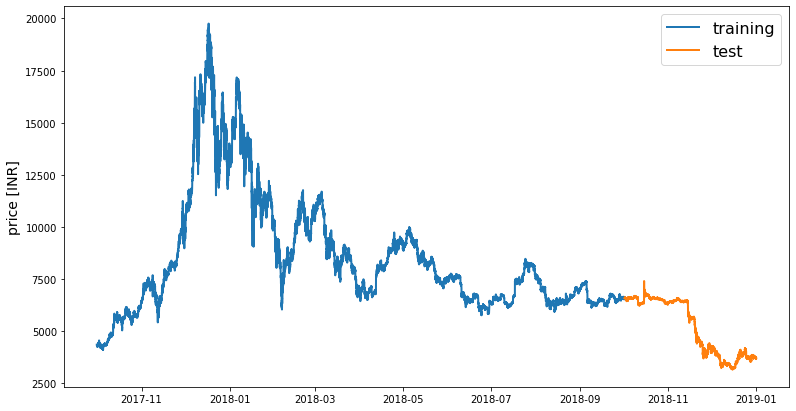

In [ ]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [ ]:
def normalise_zero_base(df):
    return df/df.max()

In [ ]:
def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

In [ ]:
def extract_window_data(df, window_len=20, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [ ]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [ ]:
window_len = 20
test_size = 0.2
zero_base = True
lstm_neurons = 32
epochs = 100
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'Nadam'

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [ ]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    opt = SGD(lr=0.01, momentum=0.9, clipnorm=1.0)
    model.compile(loss=loss, optimizer=opt)
    return model

In [ ]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 32)                4864      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
 activation_3 (Activation)   (None, 1)                 0         
                                                                 
Total params: 4,897
Trainable params: 4,897
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/100
1090/1090 [==============================] - 9s 7ms/step - loss: 0.0024
Epoch 2/100
1090/1090 [==============================] - 7s 7ms/step - loss: 6.9835e-04
Epoch 3/100
1090/1090 [==============================] - 8s 7ms/step - loss: 6.3020e-04
Epoch 4/100
1090/1090 [==============================] - 7s 7ms/step - loss: 5.9558e-04
Epoch 5/100
1090/1090 [==============================] - 7s 7ms/step - loss: 5.5791e-04
Epoch 6/100
1090/1090 [==============================] - 7s 7ms/step - loss: 5.3432e-04
Epoch 7/100
1090/1090 [==============================] - 9s 8ms/step - loss: 5.1314e-04
Epoch 8/100
1090/1090 [==============================] - 8s 7ms/step - loss: 4.9449e-04
Epoch 9/100
1090/1090 [==============================] - 8s 7ms/step - loss: 4.8090e-04
Epoch 10/100
1090/1090 [==============================] - 8s 7ms/step - loss: 4.6768e-04
Epoch 11/100
1090/1090 [==============================] - 8s 7ms/step - loss: 4.5581e-04
Epoch 12/100
1090/1090 [==========

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.004609196129352455

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

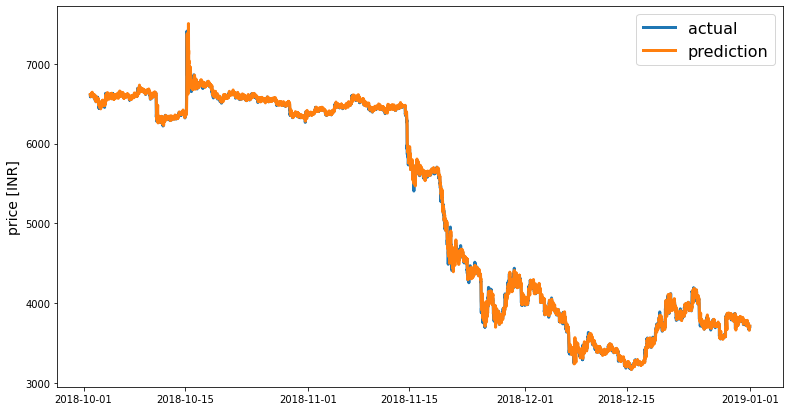

In [ ]:
line_plot(targets, preds, 'actual', 'prediction', lw=3)


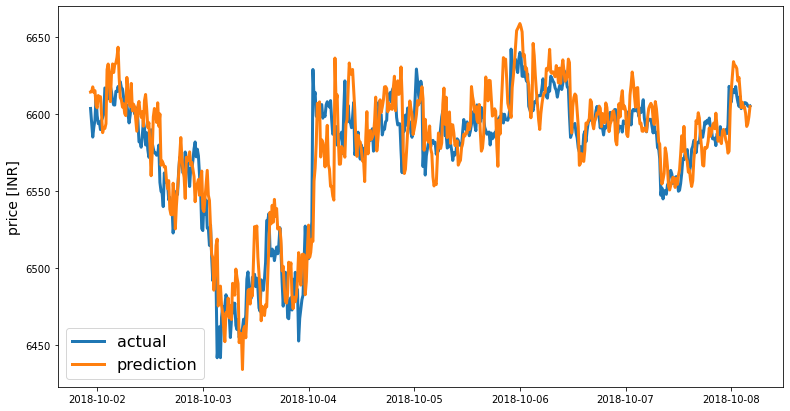

In [ ]:
line_plot(targets[:600], preds[:600], 'actual', 'prediction', lw=3)


In [ ]:

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(targets, preds , squared=False)
print("rmse: " +str(rmse))

rmse: 35.46210994735878


In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(targets, preds , squared=True)
print("mse: " +str(mse))

mse: 1257.561241918563


In [ ]:
mape=sum(abs((targets-preds)/targets))/len(targets)
print("mape: " +str(mape))

mape: 0.004613246874140599
